In [1]:
%matplotlib inline
from effective_quadratures.PolyParams import PolynomialParam
from effective_quadratures.PolyParentFile import PolyParent
from effective_quadratures.IndexSets import IndexSet
from effective_quadratures.Utils import column, evalfunction
import effective_quadratures.MatrixRoutines as mat
import effective_quadratures.ComputeStats as stats
from effective_quadratures.EffectiveQuadSubsampling import EffectiveSubsampling
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<h1> The Namesake: Effective Quadrature Subsampling

In this notebook we demonstrate what effective quadrature subsampling is and how it may be used to create a polynomial approximation for a computation model. We begin by defining a simple three-dimensional function
$$f(x_1, x_2, x_3) = exp(x_1 + x_2 + x_3)$$
where $x_1, x_2, x_3$ are uniformly distributed over the cube $x_1, x_2, x_3 
\in [-1,1]$. This will be our 'expensive' computational model. 

Lets first understand what exactly effective quadrature subsampling is and how it computes the pseudospectral coefficients. Have a look at the figure below. In (a) we have a matrix of multivariate orthonormal polynomials evaluated at a tensor grid of quadrature points (rows) and the underlying polynomial basis forms the columns. This basis can be formed from either a total order or hyperbolic cross basis. The "effectively subsampled quadrature points" are obtained by computing the QR column pivoting factorization of A transpose and only taking the first n columns of A transpose as shown in (b). We then compute the coefficients by solving this as a least squares problem. When approximating computational models with noise, one may need to eliminate a few extra columns to get a good least squares approximant; as in (c) and (d). We remark here that instead of opting for QR column pivoting, randomized sampling can also be opted for. However as we demonstrate in our paper, this is less efficient [and effective].

<img src='Matrices.png'>

To clarify the above, let us run though an example problem with the exponential function:

In [2]:
def exponential_function(x):
    return np.exp(x[0] + x[1] + x[2])

Declare the two inputs and their ranges

In [3]:
no_pts_x1 = 6
no_pts_x2 = 6
no_pts_x3 = 6
min_range = -1.0
max_range = 1.0
x1 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x1)
x2 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x2)
x3 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x3)
x1x2x3 = []
x1x2x3.append(x1)
x1x2x3.append(x2)
x1x2x3.append(x3)

We will opt for a hyperbolic cross basis, though one can also opt for a total order basis. Bear in mind that we are trying to escape the cost associated with a more conventional tensor grid or sparse grid basis. A hyperbolic cross takes in a *q* parameter. When *q=1* we have a total order basis. Note that the cardinality of the hyperbolic cross sets the maximum number of function evaluations required. 

In [4]:
q = 0.75
hyperbolic_cross = IndexSet("hyperbolic cross", [no_pts_x1, no_pts_x2, no_pts_x3], q)
maximum_number_of_evals = IndexSet.getCardinality(hyperbolic_cross)
print maximum_number_of_evals

47


Lets plot this index set which has 47 terms:

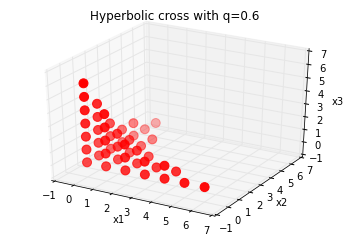

In [5]:
indexset = IndexSet.getIndexSet(hyperbolic_cross)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(column(indexset,0), column(indexset,1), column(indexset,2) , marker='o', s=80, color='red');
ax.set_xlabel('x1');
ax.set_ylabel('x2');
ax.set_zlabel('x3');
plt.title('Hyperbolic cross with q=0.6');

The class Effective_Subsampling has holds all the function calls required for effective quadrature subsampling. We begin by declaring an EffectiveSubsampling object that takes as inputs the uncertain parameters, the index set and a derivative flag. In this notebook as derivatives are not considered the derivative flag is set to 0.

In [6]:
effectiveQuads = EffectiveSubsampling(x1x2x3, hyperbolic_cross, 0)
A, esquad_pts, W = EffectiveSubsampling.getAsubsampled(effectiveQuads, maximum_number_of_evals)
A, normalizations = mat.rowNormalize(A)

Now, lets evaluate our model at the effectively subsampled quadrature points

In [7]:
b = W * np.mat(evalfunction(esquad_pts, exponential_function))
b = np.dot(normalizations, b)

Let's plot where these subsamples lie on our existing [no_pts_x1, no_pts_x2, no_pts_x3] tensor grid. 

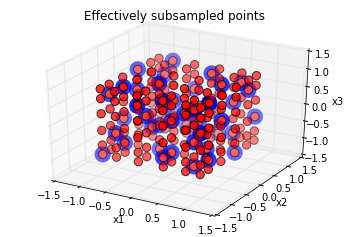

In [8]:
uqProblem = PolyParent(x1x2x3, "tensor grid")
tensor_pts, wts = PolyParent.getPointsAndWeights(uqProblem)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tensor_pts[:,0], tensor_pts[:,1], tensor_pts[:,2], s=70, c='r', marker='o');
ax.scatter(esquad_pts[:,0], esquad_pts[:,1], esquad_pts[:,2], s=150, facecolor='none', edgecolor='b', marker='o', lw=4);
ax.set_xlabel('x1');
ax.set_ylabel('x2');
ax.set_zlabel('x3');
plt.title('Effectively subsampled points');

Now we solve the least squares problem:

In [12]:
xn = mat.solveLeastSquares(A, b)
mean, variance = stats.compute_mean_variance(xn, indexset)

In [13]:
print 'MEAN & VARIANCE'
print mean, variance

MEAN & VARIANCE
1.63212957955 3.31495839725


So how does this coefficient approximation fare with the full  tensor grid -- which involves 216 points?

In [14]:
x_full, i, f = PolyParent.getCoefficients(uqProblem, exponential_function)
tensor_grid = IndexSet("tensor grid", [no_pts_x1, no_pts_x2, no_pts_x3])
tensor_index = IndexSet.getIndexSet(tensor_grid)
mean, variance = stats.compute_mean_variance(x_full, tensor_index)

In [15]:
print 'MEAN & VARIANCE'
print mean, variance

MEAN & VARIANCE
1.62306783662 3.32916876891


We can decrease the error by opting for a total order index. But recall the main point of this excercise was to escape the shear number of evaluations required from a tensor grid. 